In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.layers import Dense
#from keras.layers import LSTR
from keras.models import Sequential
from keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDRegressor as SGD
import joblib

Using TensorFlow backend.


In [5]:
time_series_df = pd.read_csv('../data/interim/time_series.csv', index_col='Date')
time_series_df = time_series_df[:-10]
time_series_df

,back_5,back_4,back_3,back_2,back_1,Adj Close
Date,,,,,,
2004-08-19,NaN,NaN,NaN,NaN,NaN,0.076433
2004-08-20,NaN,NaN,NaN,NaN,0.076433,0.010013
2004-08-23,NaN,NaN,NaN,0.076433,0.010013,-0.042289
2004-08-24,NaN,NaN,0.076433,0.010013,-0.042289,0.010718
2004-08-25,NaN,0.076433,0.010013,-0.042289,0.010718,0.017858
...,...,...,...,...,...,...
2020-02-25,0.004609,-0.005609,-0.022004,-0.043713,-0.023588,0.003401
2020-02-26,-0.005609,-0.022004,-0.043713,-0.023588,0.003401,-0.055405
2020-02-27,-0.022004,-0.043713,-0.023588,0.003401,-0.055405,0.015986


In [6]:
time_series_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3910 entries, 2004-08-19 to 2020-03-02
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   back_5     3905 non-null   float64
 1   back_4     3906 non-null   float64
 2   back_3     3907 non-null   float64
 3   back_2     3908 non-null   float64
 4   back_1     3909 non-null   float64
 5   Adj Close  3910 non-null   float64
dtypes: float64(6)
memory usage: 213.8+ KB


In [7]:
tomorrow = time_series_df.tail(1)
tomorrows_predictors = tomorrow.iloc[:,:5]
tomorrows_predictors

,back_5,back_4,back_3,back_2,back_1
Date,,,,,
2020-03-02,-0.023588,0.003401,-0.055405,0.015986,0.036494


In [8]:

time_series_df = time_series_df.dropna()
time_series_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3905 entries, 2004-08-26 to 2020-03-02
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   back_5     3905 non-null   float64
 1   back_4     3905 non-null   float64
 2   back_3     3905 non-null   float64
 3   back_2     3905 non-null   float64
 4   back_1     3905 non-null   float64
 5   Adj Close  3905 non-null   float64
dtypes: float64(6)
memory usage: 213.6+ KB


In [9]:
# create array of predictors
predictors = time_series_df[['back_5', 'back_4', 'back_3', 'back_2', 'back_1']].values
n_cols = predictors.shape[1]
type(predictors)

numpy.ndarray

In [10]:
# create array of targets
target = time_series_df[['Adj Close']].values
type(target)

numpy.ndarray

In [11]:
X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size=0.3, random_state=21)

In [12]:
#initialize a sequential keras model
model = Sequential()

# build three layers with 100 nodes each
model.add(Dense(100, activation='relu', input_shape=(n_cols,)))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))

# build final layer that will contain the output prediction
model.add(Dense(1))

# compile the model with ADAM
# will adjust the learning rate as it does gradient descent
# MSE loss function is best for regression problems
model.compile(optimizer='adam', loss='mean_squared_error')

# verify model structure
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               600       
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 20,901
Trainable params: 20,901
Non-trainable params: 0
_________________________________________________________________


In [13]:
 # fit the model
# apply back propagation and gradient descent
model.fit(X_train, y_train)

Epoch 1/1
2733/2733 [==============================] - 0s 151us/step - loss: 3.5082e-04


In [14]:
# save and load model
model.save('../models/keras.h5')
model = load_model('../models/keras.h5')

# verify model structure
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               600       
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 20,901
Trainable params: 20,901
Non-trainable params: 0
_________________________________________________________________


In [15]:
predictions = model.predict(X_test)
output = predictions
predictions = np.exp(predictions)
y_test_exp = np.exp(y_test)

In [16]:
output = pd.DataFrame(output)
output.to_csv('../data/interim/keras_dense_predictions.csv')

In [17]:
scores = [53.964194, 45.865303, 53.878943, 53.793691]

In [18]:
#### this is very good

def get_accuracy(y, pred):
    
    #scale and shift binary results
    # -1 >> stock went down
    # +1 >> stock increased or stayed the same
    y = ((y>=1)*2)-1
    pred = ((pred>=1)*2)-1
    
    # stocks move in the same direction when a_i*b_i is positive
    accuracy = (np.sum((y*pred)>=0)/len(y))*100
    
    print("Predicting change in stock price with %f%s accuracy" % (accuracy,'%'))
    
    return accuracy

scores.append(get_accuracy(y_test_exp, predictions))

Predicting change in stock price with 52.815700% accuracy


# trading dates where COVID-19 affected stock market need to be excluded. if included, accuracy drops to ~48%

In [19]:
scores

[53.964194, 45.865303, 53.878943, 53.793691, 52.815699658703075]

In [20]:
def predict_tomorrow():
    X = tomorrows_predictors.values
    prediction = model.predict(X)
    prediction = np.exp(prediction)
    adj_close = pd.read_csv('../data/raw/raw.csv', usecols=['Adj Close'], )
    prices = adj_close.tail(1)
    todays_price = float(prices.values[0])
    tomorrows_price = float(todays_price) * float(prediction)
    is_increase = bool(prediction>=1)
    return todays_price, tomorrows_price, is_increase

predict_tomorrow()
    

(1084.3299560546877, 1087.0275289837011, True)

In [15]:
def revert_data(predictions):
    
    # undo scale
    #scaler = joblib.load('../models/MinMaxScaler.save')
    #unscaled_deltas = scaler.inverse_transform(predictions)
    
    # undo log
    #inv_log = np.exp(unscaled_deltas)
    inv_log = np.exp(predictions)
    
    return inv_log
x = revert_data(predictions)
(x.min(), x.max())

(0.9923569, 0.9992936)

In [25]:

scaler = joblib.load('../models/MinMaxScaler.save')
unscaled_deltas = scaler.inverse_transform(predictions)
unscaled_deltas

scaler.inverse_transform([[0.81, 0.12, 3.3], [0,1, -2]])

array([[ 0.12417709, -0.08672323,  0.88525218],
       [-0.12340155,  0.1822511 , -0.73470684]])

In [26]:
x1 = np.array([[ 0.12417709, -0.08672323,  0.88525218],[-0.12340155,  0.1822511 , -0.73470684]])
scaler.transform(x1)

array([[ 8.09999986e-01,  1.20000001e-01,  3.30000000e+00],
       [-7.64619668e-09,  1.00000001e+00, -2.00000001e+00]])

In [15]:
inv_log = np.exp(predictions)
inv_log

array([[1.5125663],
       [1.4969895],
       [1.5091519],
       ...,
       [1.4781057],
       [1.5097255],
       [1.5126888]], dtype=float32)

In [21]:
inv_log.min(), inv_log.max()

(1.3813076, 1.7587633)

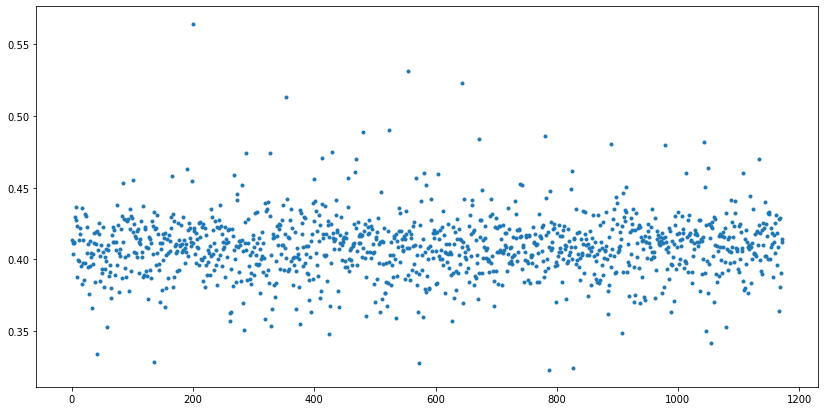

In [16]:
_ = plt.figure(figsize=(14,7))
_ = plt.plot(predictions, linestyle='None', marker='.')
plt.show()

In [17]:
def get_Dense_model(input_shape):
    #initialize a sequential keras model
    model = Sequential()

    # build three layers with 100 nodes each
    model.add(Dense(100, activation='relu', input_shape=input_shape))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))

    # build final layer that will contain the output prediction
    model.add(Dense(1))

In [ ]:
def get_LSTR_model(input_shape):
    # Matt and Druv's architecture
    #initialize a sequential keras model
    model = Sequential()

    # build three layers with 100 nodes each
    model.add(LSTR(50, return_sequence=True, input_shape=input_shape))
    model.add(LSTR(50, return_sequence=True)
    model.add(LSTR(50))

    # build final layer that will contain the output prediction
    model.add(Dense(1))
    
    mode.complile(loss='mse', optimizer='adam')
    
              

In [18]:
lr_to_test = [0.00001, 0.01, 1]
input_shape = (n_cols,)

# loop over learning rates
for lr in lr_to_test:
    model = get_new_model(input_shape)
    
    # use Stochastic Gradient Descent
    optimizer = SGD(lr=lr)
    
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    
    mse = sum((predictions - y_test)**2)
    
    print(lr, mse)

TypeError: __init__() got an unexpected keyword argument 'lr'